<a href="https://colab.research.google.com/github/MonikSense/Diabetes/blob/main/Ganesh1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Dataset Loaded Successfully!
Shape: (100000, 9)
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Numerical Columns: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Categorical Columns: ['gender', 'smoking_history']

Data Split:
Train: (70000, 8)
Validation: (15000, 8)
Test: (15000, 8)

🔹 Train

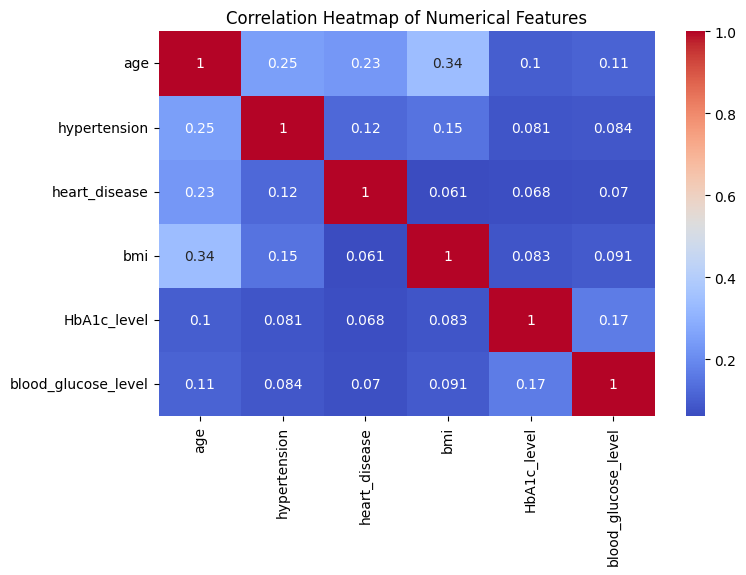

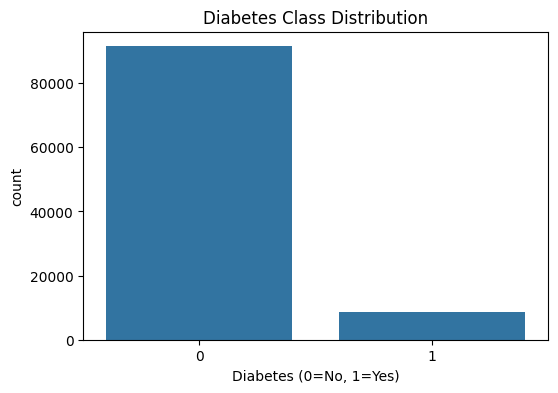

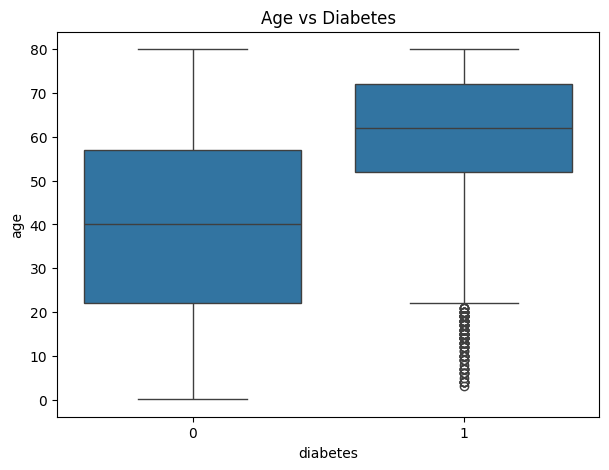

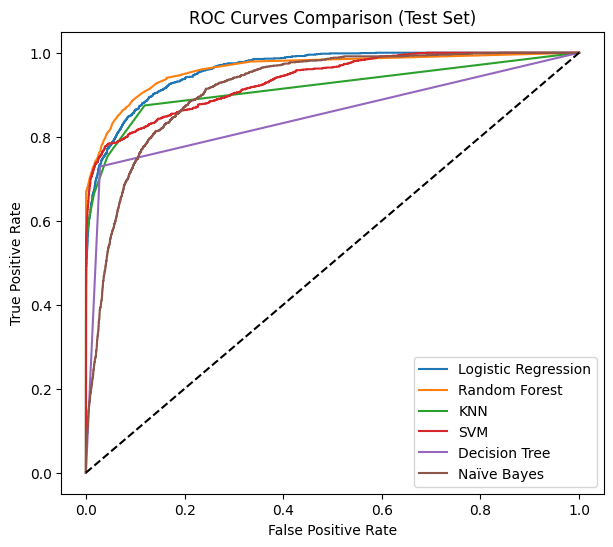

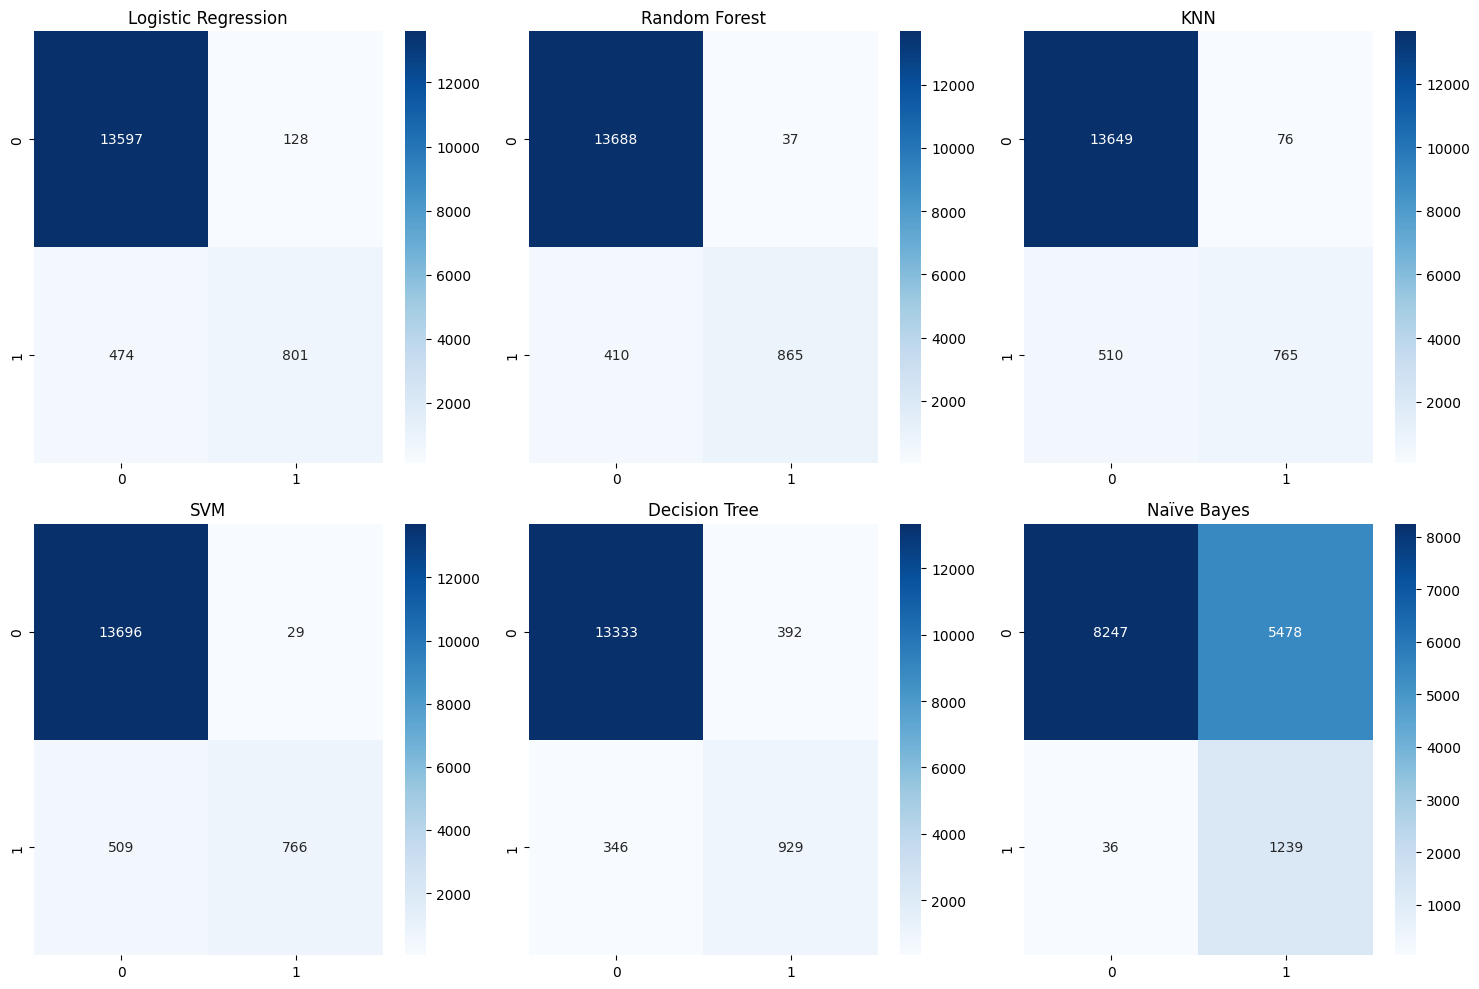

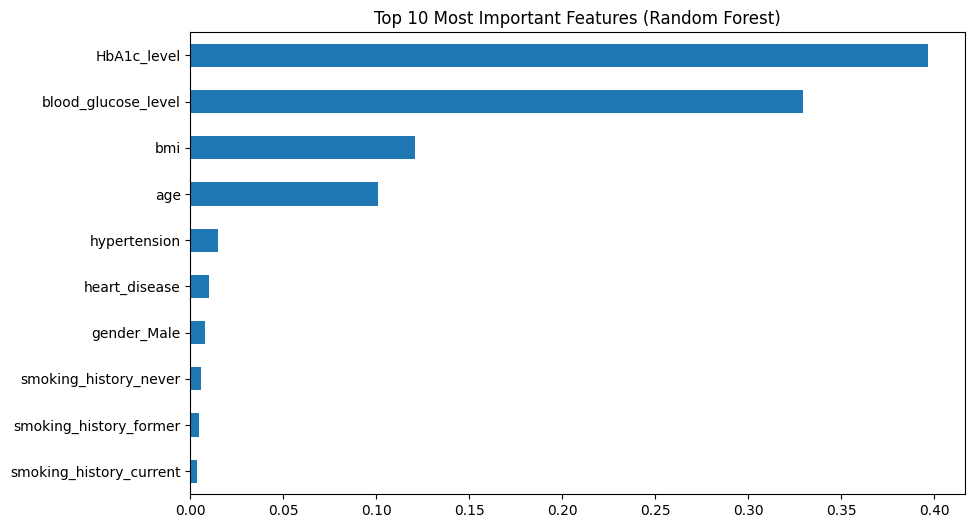

In [1]:
# ============================================================
# Diabetes Early Detection using EHR + Multiple ML Classifiers
# Supervised Models: LR, RF, KNN, SVM, DT, Naive Bayes
# ============================================================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")


# 2️⃣ Load Dataset
df = pd.read_csv("https://raw.githubusercontent.com/MonikSense/Diabetes/refs/heads/main/diabetes_prediction_dataset.csv")
print("\nDataset Loaded Successfully!")
print("Shape:", df.shape)
print(df.head())


# 3️⃣ Feature & Target Separation
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Identify numeric & categorical features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nNumerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)


# 4️⃣ Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ]
)


# 5️⃣ Train / Validation / Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("\nData Split:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


# 6️⃣ Build Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(probability=True, kernel="rbf"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB()
}

performance = {}


# Train + Evaluate
for name, model in models.items():
    print(f"\n🔹 Training: {name}")

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)

    # Validation & Test Predictions
    for dataset, Xt, yt, tag in [
        ("Validation", X_val, y_val, "val"),
        ("Test", X_test, y_test, "test")
    ]:
        y_pred = pipe.predict(Xt)
        y_prob = pipe.predict_proba(Xt)[:, 1] if hasattr(pipe, "predict_proba") else None

        performance.setdefault(name, {})[f"{tag}_acc"] = accuracy_score(yt, y_pred)
        performance[name][f"{tag}_precision"] = precision_score(yt, y_pred)
        performance[name][f"{tag}_recall"] = recall_score(yt, y_pred)
        performance[name][f"{tag}_f1"] = f1_score(yt, y_pred)
        performance[name][f"{tag}_auc"] = roc_auc_score(yt, y_prob) if y_prob is not None else np.nan

        print(f"{dataset} Accuracy: {performance[name][f'{tag}_acc']:.3f} | AUC: {performance[name][f'{tag}_auc']:.3f}")


# 7️⃣ Performance Comparison Table
results_df = pd.DataFrame(performance).T
print("\n📊 Model Performance Comparison:")
print(results_df)


# ==============================
# 📈 Visualizations
# ==============================

# 🔹 Correlation Heatmap (numerical features)
plt.figure(figsize=(8,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


# 🔹 Diabetes Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Diabetes Class Distribution")
plt.xlabel("Diabetes (0=No, 1=Yes)")
plt.show()


# 🔹 Age vs Diabetes
plt.figure(figsize=(7,5))
sns.boxplot(x=y, y=df["age"])
plt.title("Age vs Diabetes")
plt.show()


# 🔹 ROC Curve Comparison (Test Data)
plt.figure(figsize=(7,6))
for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    if hasattr(pipe, "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name}")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison (Test Set)")
plt.legend()
plt.show()


# 🔹 Confusion Matrices (Test Data)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.ravel()

for ax, (name, model) in zip(axes, models.items()):
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(name)

plt.tight_layout()
plt.show()


# 8️⃣ Feature Importance (Tree-Based Models Only)
rf = Pipeline([("preprocessor", preprocessor),
               ("model", RandomForestClassifier(random_state=42))])
rf.fit(X_train, y_train)

feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + feature_names

importances = rf.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp[:10].plot(kind='barh')
plt.title("Top 10 Most Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()
